# Analysis of household air-moisture levels

As part of an ongoing analysis to derive metadata from a timeseries we're using some household data at the 1 minute level to display temperature & humidity levels in our house in 2 rooms.

We then back-calculate the moisture level (grams per metre cubed) for the actual amount of water in a cubed meter or air near the sensor, to get an understanding of where the most or least water is in the house and which household events affect these levels.

We can use similar processes to derive signals for work-releated problems on our own timeseries data, this analysis combines both work and play and will be used as an internal proof-of-concept to get sign-off from the team for running a similar project on internal business data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import numpy as np

df = pd.read_csv('Kitchen_export_202112311652.csv', parse_dates=True)

# and then we can rename the columns to something sane
df.columns = ['timestamp', 't_c', 'rh']

df['timestamp'] = pd.to_datetime(df.reset_index()['timestamp'])

#df = df.set_index('timestamp')
df.set_index('timestamp', inplace=True)
print(f"Date range {df.index.min()} - {df.index.max()}")

# now let's choose a day
day_to_choose = '2021-12-24'

Date range 2021-12-22 17:00:00 - 2021-12-31 16:52:00


In [2]:
dfh = df.resample('30min').mean()
dfh.tail(5)

,t_c,rh
timestamp,,
2021-12-31 14:30:00,18.393333,68.936667
2021-12-31 15:00:00,18.300000,68.963333
2021-12-31 15:30:00,18.230000,68.300000
2021-12-31 16:00:00,18.266667,69.536667
2021-12-31 16:30:00,18.378261,71.147826


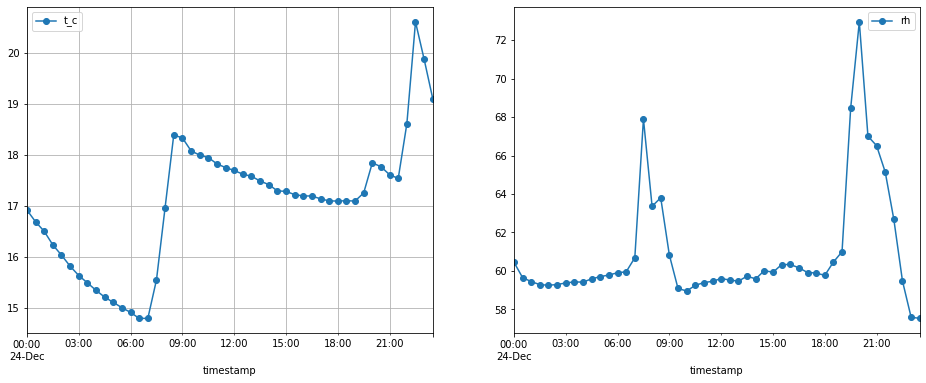

In [3]:
dfx = dfh.loc[day_to_choose].reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
dfx.plot(x='timestamp', y='t_c', marker='o', ax=axs[0])
dfx.plot(x='timestamp', y='rh', marker='o', ax=axs[1])
axs[0].grid(which='both')

In [8]:
import numpy as np
# saturation pressure
# ps = 610.78 *exp( t / ( t + 238.3 ) *17.2694 ) 
# via https://www.conservationphysics.org/atmcalc/atmoclc1.html
# TODO this won't work for negative values, we should probably warn my future self
ts = np.arange(0, 31, 0.1)
satp = 610.78 *np.exp(ts/(ts+238.3) * 17.2694)

max_water_gm3_at_temp = 0.002166 *satp / ( ts + 273.16 ) * 1000
max_water_gm3_at_temp[:5]
df_moisture = pd.DataFrame({'t_c': ts, 
                            'max_water_gm3': max_water_gm3_at_temp})
df_moisture = df_moisture.set_index('t_c')
df_moisture.head()

,max_water_gm3
t_c,
0.0,4.843130
0.1,4.876555
0.2,4.910182
0.3,4.944011
0.4,4.978044


In [9]:

df_hw = pd.merge_asof(dfh.sort_values('t_c'), df_moisture, left_on='t_c', right_index=True).sort_index()
df_hw.head(2)

,t_c,rh,max_water_gm3
timestamp,,,
2021-12-22 17:00:00,13.916667,48.226667,11.938047
2021-12-22 17:30:00,13.756667,48.800000,11.792656


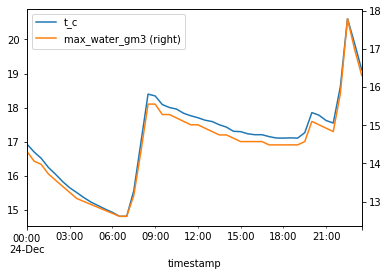

In [13]:
ax = df_hw.loc[day_to_choose][['t_c', 'max_water_gm3']].plot(secondary_y=['max_water_gm3'])
plt.savefig('max_water_first_go.png')

In [14]:
df_hw['est_water_gm3'] = df_hw['max_water_gm3'] * df_hw['rh'] / 100
df_hw.head(2)

,t_c,rh,max_water_gm3,est_water_gm3
timestamp,,,,
2021-12-22 17:00:00,13.916667,48.226667,11.938047,5.757322
2021-12-22 17:30:00,13.756667,48.800000,11.792656,5.754816
